# <center> <font color='blue'> PROJETO: Prevendo o Nível de Satisfação dos Clientes do Santander

<justify> Neste projeto iremos utilizar dados dos clientes do santander para avaliar o nível de satisfação dos mesmos, tais informações serão de grande utilizade para avaliação de campanhas capazes de aumentar o nível de satisfação de clientes insatisfeitos e manter a alta satisfação dos demais. O principal desafio a nossa frente é apresentar um modelo com acurácia superior a 70% para identificar clientes insatisfeitos.

## <center> <font color='blue'> FERRAMENTAS  

In [1]:
#Importando as bibliotecas a serem utilizadas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay  
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.utils import compute_sample_weight
import warnings
from scipy import stats
from minhas_funcoes import *

In [2]:
warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 14})

## <center> <font color='blue'> ANÁLISE EXPLORATÓRIA DOS DADOS

In [3]:
#Carregando os dados
#iremos carregar os dados em um df para realizar análise exploratória

df = pd.read_csv("datasets/train.csv")

In [4]:
#O dataset é constituido por 371 variáveis preditoras e 76020 observações

df.shape

(76020, 371)

In [5]:
#Cinco primeiras observações

df.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


<justify>O dataset apresenta um elevado número de variváveis (370), o que pode ser levemente problemático...

In [6]:
#A variável ID presente no dataset não apresenta nenhuma informação relevante para a análise de satsfação, dito isto 
#iremos excluir
df = df.iloc[:,1:]
df.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [7]:
df.describe()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,3.160715,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,95.268204,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,8237.820000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [8]:
#Distribuição da variável alvo
df["TARGET"].value_counts().sort_index()

0    73012
1     3008
Name: TARGET, dtype: int64

A variável alvo em nosso estudo encontra se extremamente desbalanceada

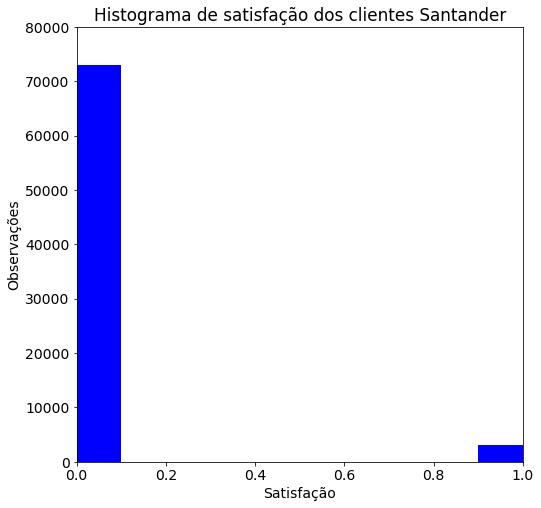

In [9]:
#Graficamente
plt.subplots(figsize=(8,8))
plt.hist(df["TARGET"], facecolor='b', alpha=1)
plt.xlabel('Satisfação')
plt.ylabel('Observações')
plt.title('Histograma de satisfação dos clientes Santander')
plt.xlim(0, 1)
plt.ylim(0, 80000)
plt.grid(False)
plt.show()

O nível de satisfação é representado pelos valores numéricos 0 e 1, onde 0 representa os clientes satisfeitos e 1 os clientes insatisfeitos com os serviços do Santander.

In [10]:
df.shape

(76020, 370)

In [11]:
X = df.iloc[:,0:335]
y = pd.DataFrame(df["TARGET"])

In [12]:
# removendo colunas com valores únicos
colunas = []
for coluna in X:
    if len(np.unique(df[coluna])) == 1:
        colunas.append(coluna)

X.drop(colunas, axis=1, inplace=True)

#Nome das colunas do dataframe
coluna = X.columns

#localizando indices dos outliers
indices_out = tratamento_outliers(X, coluna)

#removendo outliers de acordo com o Z-escore
x_s_out = X.drop(indices_out)
y_s_out = y.drop(indices_out)

In [13]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, stratify=y, random_state=42, shuffle=True)

In [14]:
#escalonando as variáveis de treino

escalonador = StandardScaler()
X_treino_esc = escalonador.fit_transform(X_treino)
X_teste_esc = escalonador.transform(X_teste)

## <center> <font color='blue'> TREINANDO MODELO XGBOOST

### <center> <font color='blue'> Modelo base

In [15]:
xgb_base = xgb.XGBClassifier(use_label_encoder=False, random_state=42) #scale_pos_weight=24


In [16]:
xgb_base.fit(X_treino_esc,np.ravel(y_treino))

[21:53:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

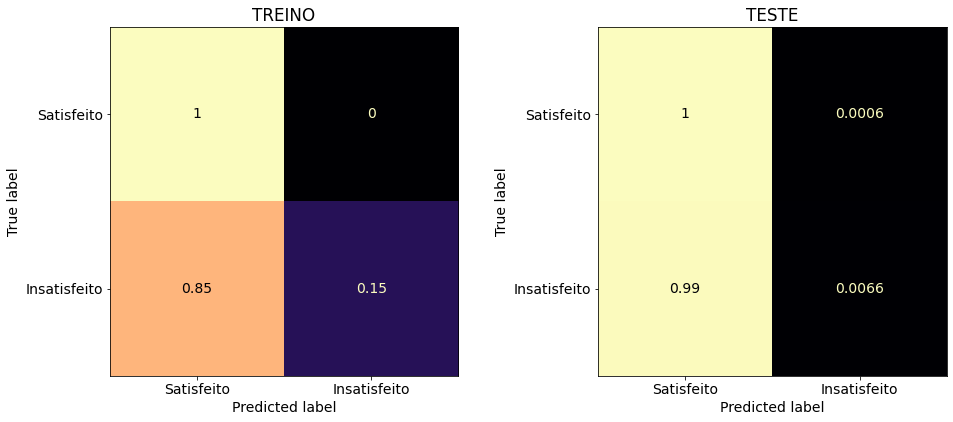

In [17]:
plot_multiple_cm(xgb_base, X_treino_esc, X_teste_esc, y_treino, y_teste)

### <center> <font color='blue'> Modelo aprimorado

In [18]:
xgb_best  = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
               eval_metric='logloss', gamma=0.0, gpu_id=-1, importance_type=None,
               interaction_constraints='', learning_rate=0.25, max_delta_step=0,
               max_depth=4, min_child_weight=1,
               monotone_constraints='()', n_estimators=100, n_jobs=8,
               num_parallel_tree=1, predictor='auto', random_state=42,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
               tree_method='exact', use_label_encoder=False,
               validate_parameters=1, verbosity=None)

In [19]:
#Treinando o melhor modelos pós grid search com peso balanceado para equilibrar o desbalanceamento de classes
peso_classe_balanceado = compute_sample_weight("balanced", y_treino)

xgb_best.fit(X_treino_esc, y_treino, sample_weight=peso_classe_balanceado);

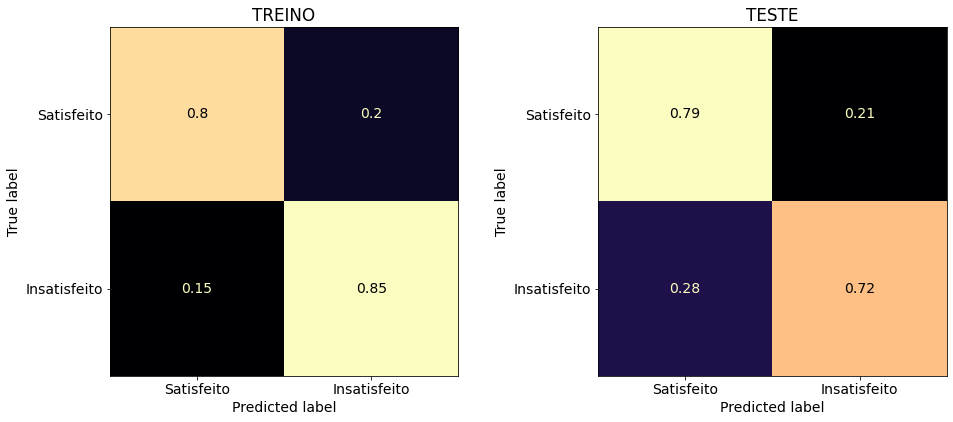

In [20]:
plot_multiple_cm(xgb_best, X_treino_esc, X_teste_esc, y_treino, y_teste)

In [21]:
#Métricas finais...
y_previsto = xgb_best.predict(X_teste_esc)

print(classification_report(y_teste,y_previsto))

              precision    recall  f1-score   support

           0       0.99      0.79      0.88     18253
           1       0.12      0.72      0.21       752

    accuracy                           0.79     19005
   macro avg       0.55      0.75      0.54     19005
weighted avg       0.95      0.79      0.85     19005

